# **Projeto Netflix: Clustering Movies and Series**

## **1. Explorando a base**

_**Objetivo:**_ Criar novas listas de músicas agrupando-as com base em suas características para sugerir novas playlists.

Tipo de modelo: **Não Supervisionado**

Técnica: **Clusterização**

Técnicas para definir clusters: Silhouette e Elbow.

Algoritmo: KMeans

**Descrição das colunas**

| Atributo                | Descrição                                      |
|------------------------|------------------------------------------------|
| track_name             | Nome da música                                  |
| artist(s)_name          | Nome do(s) artista(s) que performa(m) a música |
| artist_count            | Número de artistas contribuindo na música      |
| released_year           | Ano de lançamento                               |
| released_month          | Mês de lançamento                               |
| released_day            | Dia de lançamento                               |
| in_spotify_playlists     | Número de playlists no Spotify onde a música está |
| in_spotify_charts       | Posição da música nas paradas do Spotify        |
| streams                 | Total de streams no Spotify                      |
| in_apple_playlists      | Presença em playlists do Apple Music             |
| in_apple_charts         | Presença nas paradas do Apple Music               |
| in_deezer_playlists     | Presença em playlists do Deezer                    |
| in_deezer_charts        | Presença nas paradas do Deezer                      |
| in_shazam_charts        | Posição nas paradas do Shazam                       |
| bpm                     | Batidas por minuto (tempo da música)               |
| key                     | Tom da música                                      |
| mode                    | Modo maior ou menor                                 |
| danceability_%          | Adequação para dança (%)                            |
| valence_%               | Positividade do conteúdo musical (%)               |
| energy_%                | Nível de energia percebido (%)                      |
| acousticness_%          | Presença de som acústico (%)                         |
| instrumentalness_%      | Proporção de conteúdo instrumental (%)              |
| liveness_%              | Presença de elementos de performance ao vivo (%)   |
| speechiness_%           | Quantidade de palavras faladas (%)                   |

Importando bibliotecas:

In [1]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math
import os
import warnings
from ipywidgets import IntSlider, interact
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Funções auxiliares.

In [2]:
def count_types(df):
    # Colunas numéricas (int, float, etc.)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Colunas de data/hora
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    
    # Colunas categóricas (object, category)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    return f"numerica: {len(numeric_cols)}, categorica: {len(categorical_cols)}, datetime:{len(datetime_cols)}"

Importando e criando dataframe de nosso dataset.

In [3]:
# Obtém o diretório de trabalho atual
current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

# Constrói o caminho completo para o arquivo CSV
csv_path1 = os.path.join(parent_dir, 'base_de_dados', 'Spotify.csv')

# Ignora todas as mensagens de aviso, evitando que apareçam no terminal durante a execução do código.
warnings.filterwarnings("ignore")

df = pd.read_csv(csv_path1,delimiter=',',encoding='latin1')

### **1.1 Alinhamento com o negócio**

- Quantidade de cluster: no mínimo 4, a intenção é descbrir novas listas de indicação de músicas
- Os artistas mais populares são os que possuem maiores streams
- Variáveis consideradas: O dataset fornecido para análise já considera as colunas importantes para a regra de negócio

Observações do cientista:
- Para a determinação da quantidade de Cluster iremos utilizar o método do cotovelo e o coeficiente de silhueta
- Iremos usar a distência euclidiana (k-means) para a fase de clusterização

### **1.2 Entendimento dos dados**

Visualizando base de dados.

In [4]:
display(df.head(3))

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...


In [5]:
print(f"""As colunas do dataset são:
{pd.DataFrame(df.columns.values)}
""")

As colunas do dataset são:
                       0
0             track_name
1         artist(s)_name
2           artist_count
3          released_year
4         released_month
5           released_day
6   in_spotify_playlists
7      in_spotify_charts
8                streams
9     in_apple_playlists
10       in_apple_charts
11   in_deezer_playlists
12      in_deezer_charts
13      in_shazam_charts
14                   bpm
15                   key
16                  mode
17        danceability_%
18             valence_%
19              energy_%
20        acousticness_%
21    instrumentalness_%
22            liveness_%
23         speechiness_%
24             cover_url



Características básicas.

In [6]:
print('Número de instâncias do dataset : {}'.format( df.shape[0]))
print('Número de atributos do dataset: {}'.format( df.shape[1]))
print('Número de valores ausentes: {}'.format( df.isnull().sum().sum()))

Número de instâncias do dataset : 953
Número de atributos do dataset: 25
Número de valores ausentes: 145


In [7]:
df['key'].unique()

array(['B', 'C#', 'F', 'A', 'D', 'F#', nan, 'G#', 'G', 'E', 'A#', 'D#'],
      dtype=object)

**Observações:** A base de dados possui 953 linhas com 25 colunas.

Verificando valores duplicados.

In [8]:
print(df.duplicated().sum())

0


Tipos de variáveis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

Será necessário converter os valores da tabela para o tipo correto.

In [10]:
# separando em listas: variáveis numéricas e categóricas
num_vars = df.select_dtypes(include=['number']).columns.tolist()  # Seleciona as colunas com tipo numérico

cat_vars = df.select_dtypes(exclude=['number']).columns.tolist()  # Seleciona as colunas que não são numéricas (categóricas)


print('Número de tipos de dados: {}'.format( count_types(df)))
print("Variáveis Numéricas:", num_vars)  # Imprime as variáveis numéricas
print("Variáveis Categóricas:", cat_vars)  # Imprime as variáveis categóricas
print("Qtd Variáveis Numéricas:", len(num_vars))  # Imprime a quantidade de variáveis numéricas
print("Qtd Variáveis Categóricas:", len(cat_vars))  # Imprime a quantidade de variáveis categóricas

Número de tipos de dados: numerica: 17, categorica: 8, datetime:0
Variáveis Numéricas: ['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
Variáveis Categóricas: ['track_name', 'artist(s)_name', 'streams', 'in_deezer_playlists', 'in_shazam_charts', 'key', 'mode', 'cover_url']
Qtd Variáveis Numéricas: 17
Qtd Variáveis Categóricas: 8


Missing e zeros: calcular percentual de valores ausentes e zeros para cada variável

In [11]:
# Percentual de valores ausentes (NaN)
missing_percent = df.isnull().mean() * 100 

# Percentual de zeros
zeros_percent = (df == 0).mean() * 100

# DataFrame com os resultados
missing = pd.DataFrame({
    'features': df.columns,
    'missing': missing_percent,
    'zeros': zeros_percent 
})

# Resetando o índice para garantir que não haja problemas com duplicação de colunas
missing.reset_index(drop=True, inplace=True)

# Ordenar o DataFrame pelas variáveis com maior percentual de valores ausentes
missing = missing.sort_values(by='missing', ascending=False)  # Ordena o DataFrame pela coluna 'missing', de forma decrescente.

# Exibir o DataFrame corrigido com a coluna 'features' com o nome correto
missing = missing[['features', 'missing', 'zeros']]  # Selecionando apenas as colunas desejadas

# Exibir o DataFrame final
missing

,features,missing,zeros
15,key,9.96852,0.000000
13,in_shazam_charts,5.24659,0.000000
2,artist_count,0.00000,0.000000
1,artist(s)_name,0.00000,0.000000
4,released_month,0.00000,0.000000
5,released_day,0.00000,0.000000
6,in_spotify_playlists,0.00000,0.000000
3,released_year,0.00000,0.000000
0,track_name,0.00000,0.000000
8,streams,0.00000,0.000000


**Observações:**
- Não foram encontradas instâncias duplicadas
- Base possui 25 variáveis
- 17 variáveis numéricas
- 8 variáveis categóricas
- Nunhum valor duplicado
- As colunas in_spotfy_charts, in_deezer_charts e instrumentalness_% possuem uma porcentagem alta de valores zerados. Para os casos in_spotfy_charts e in_deezer_charts podemos considerar como válido pois retratam a presença da música em uma playkist e isso pode ou não ocorrer. Para o caso de instrumentalness_% que seria a proporção de instrumental na música ter muitos valores zerados pode ser estranho. Talvez seja necessário desconsiderar essa coluna
- Para a coluna key, podemos trocar os valores nulos por unknown
- Colunas cadidatas para a aplicação do KMeans: "bpm", "danceability_%", "energy_%", "valence_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"

### **1.3 Estatísticas básicas**

In [12]:
display(df.describe(percentiles=[0.25, 0.5, 0.75]))

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


**Observações:**

- bpm: ritmo em sua maioria moderado e animado com valor médio aproximado de 120 BPM
- danceability_%: média acima de 60%, indicando maioria de músicas dançantes
- energy_%: média acima de 60%, indicando ritmo forte
- valence_%: média acima de 50% indicando emoções equilibradas
- acousticness_%: média baixa indicada pala alta quantidade de zeros, maioria das músicas produzidas por instrumentos eletrônicos
- instrumentalness_%: média próxima de 2%, a maioria das músicas possui vocais
- speechiness_%: média de 10% com máximo de 64% indicando presença de raps
- liveness_%: média de 18% com 50%-75% das música com nível de liveness_% médio variando entre 10%-24% com um máximo de 97% indicando a presença de músicas gravadas em ambientes abertos como shows e com efeitos de plateia

### **1.4 Gráficos**

#### **1.4.1 Variáveis Categóricas**

In [13]:
df[cat_vars].apply( lambda x: x.unique().shape[0] )

track_name             943
artist(s)_name         645
streams                949
in_deezer_playlists    348
in_shazam_charts       199
key                     12
mode                     2
cover_url              535
dtype: int64

* Popularidade de Artistas: Talvez misturar as músicas dos artistas mais populares com artistas menos populares para alavancar eles ou  fazer uma lista focada em popularidade e estilo.

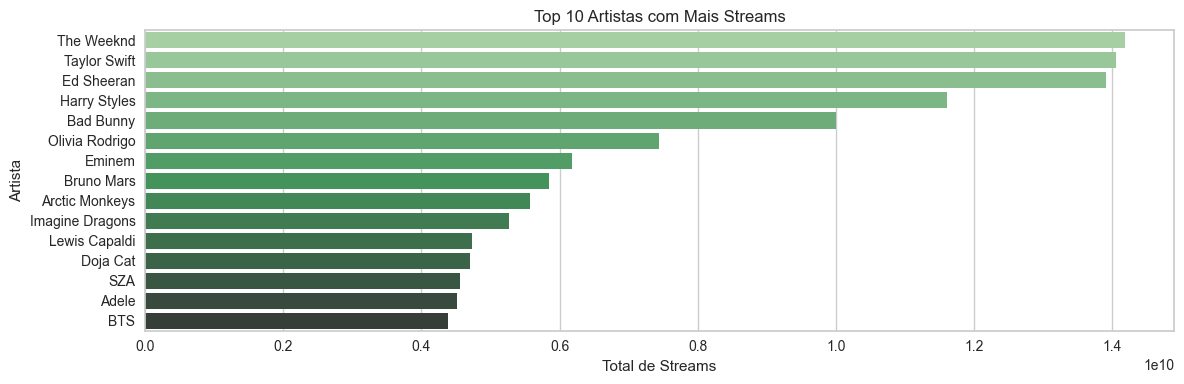

In [28]:
qtd_artistas = 15

# Agrupar por artista e somar os streams
top_artistas = (df.groupby("artist(s)_name")["streams"].sum().sort_values(ascending=False).head(qtd_artistas).reset_index())

# Gráfico de barras
plt.figure(figsize=(12, 4))
sns.barplot(data=top_artistas, x="streams", y="artist(s)_name", palette="Greens_d")
plt.title("Top 10 Artistas com Mais Streams")
plt.xlabel("Total de Streams")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()

* Popularidade de Músicas

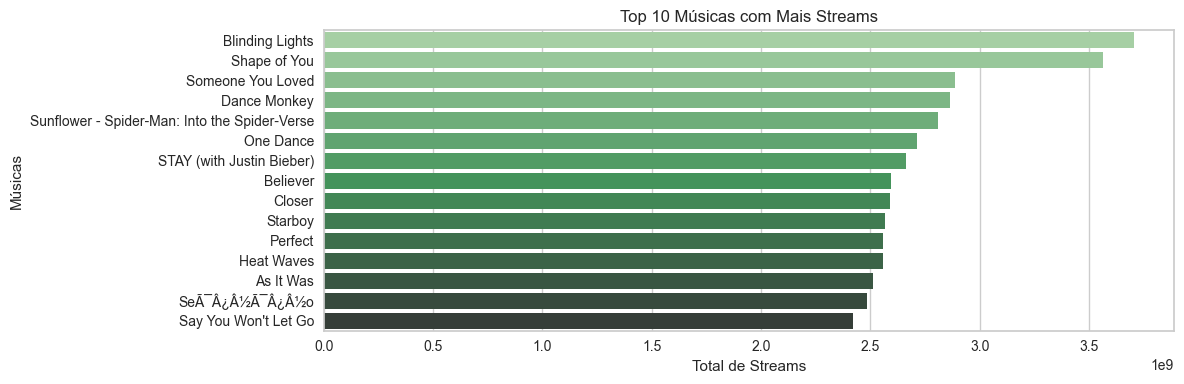

In [27]:
qtd_músicas = 15

# Agrupar por artista e somar os streams
top_musicas = (df.groupby("track_name")["streams"].sum().sort_values(ascending=False).head(qtd_artistas).reset_index())

# Gráfico de barras
plt.figure(figsize=(12, 4))
sns.barplot(data=top_musicas, x="streams", y="track_name", palette="Greens_d")
plt.title("Top 10 Músicas com Mais Streams")
plt.xlabel("Total de Streams")
plt.ylabel("Músicas")
plt.tight_layout()
plt.show()

#### **1.4.2 Variáveis numéricas**

* Streams vs métricas

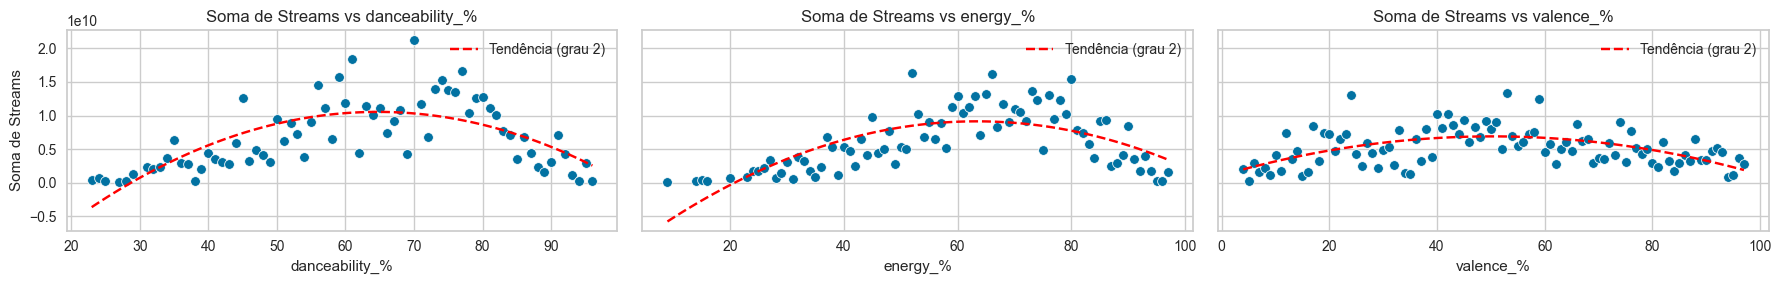

In [16]:
stream_cols = ["danceability_%", "energy_%", "valence_%"]

# Converter a coluna 'streams' para numérica
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

# Criar gráficos de dispersão com soma de streams, lado a lado
stream_cols = ["danceability_%", "energy_%", "valence_%"]

fig, axes = plt.subplots(1, len(stream_cols), figsize=(18, 3), sharey=True)

for i, col in enumerate(stream_cols):
    grouped = df.groupby(col)['streams'].sum().reset_index()
    sns.scatterplot(data=grouped, x=col, y="streams", ax=axes[i])
    
    # Ajustar uma linha de tendência polinomial de grau 2
    z = np.polyfit(grouped[col], grouped["streams"], 2)
    p = np.poly1d(z)
    x = np.linspace(grouped[col].min(), grouped[col].max(), 100)
    axes[i].plot(x, p(x), color='red', linestyle='--', label='Tendência (grau 2)')
    
    axes[i].set_title(f'Soma de Streams vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Soma de Streams' if i == 0 else '')
    axes[i].legend()

plt.tight_layout()
plt.show()

**Observação:** Temos três curvas de tendência para daceability_% e energy_% temos o pico nos 60% e valence_% temos o pico entre 40% a 60%, provavelmente as músicas mais populares ficam nesses intervalos de qualidade.

* Boxplot

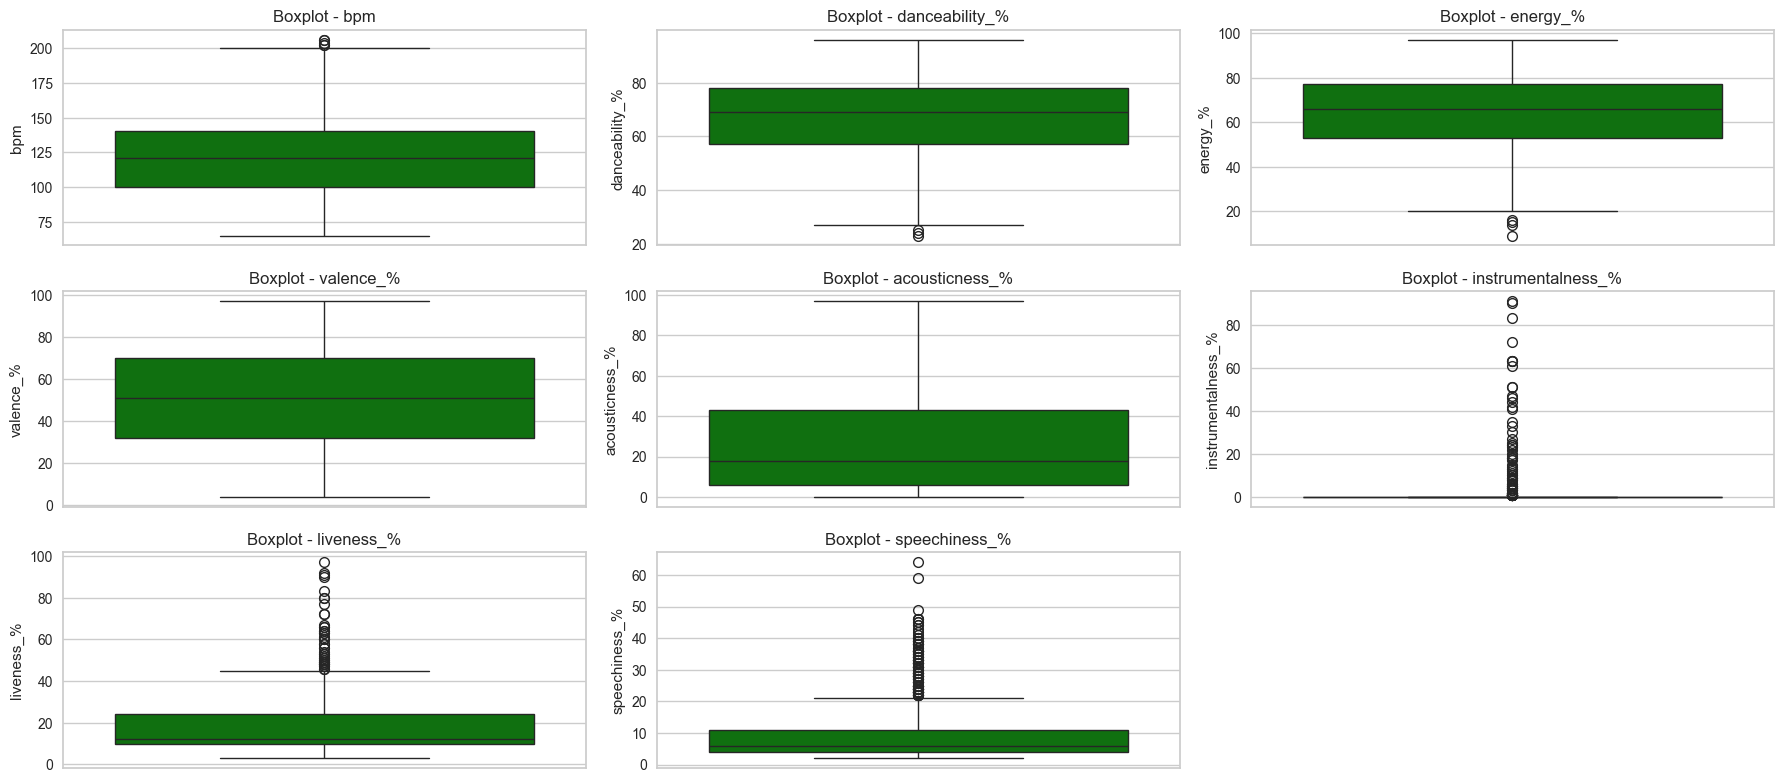

In [17]:
cols = ["bpm", "danceability_%", "energy_%", "valence_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))
axs = axs.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axs[i], color='green')
    axs[i].set_title(f'Boxplot - {col}')
    axs[i].set_ylabel(col)

# Remove gráfico vazio (caso tenha)
for j in range(len(cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


**Observações:**
- instrumentalness_% temos muitos outliers, provavelmente por conta de muitos valores zerados, vamos desconsiderá-lo para nossa análise;
- bpm temos uma maior concentração de músicas entre 100 e 140 bpm com poucos outliers e temos uma distribuição simétrica entre máximo e mínimo;
- danceability_% temos concentração entre 60% a 80% de dançabilidade com mediana próxima dos 80% e com poucos outliers, isso nos indica que as músicas desse dataset em sua mairia buscam ser bem dançantes fazendo sentido com o ranking de popularidade dos artistas;
- energy_% temos concentração de valores entre 50% e 80% indicando que a maioria das múscias são energéticas;
- valence_% possui uma mediana de 50% e sem nenhum outlier, faz sentido com o contexto do dataset, mpusicas buscam transparecer emoções;
- acousticness_% mediana em torno de 20%, o que indica baixa presença de sons acústicos em geral, faz sentido com o dataset pois o Spotify possui em sua maioria músicas gravadas e tratadas em estúdio;
- liveness_% distribuição assimétrica, inicando poucos elementos ao vivo;
- speechiness_% o esperado é encontrar concentração abaixo de 20% representando valores com pouca fala fato comum para músicas cantadas, mas os outliers concentrados acima disso indicam presença de músicas com falas intensas como rap, coincidindo com o artista Eminem que aparece no top 10;

* Histogramas

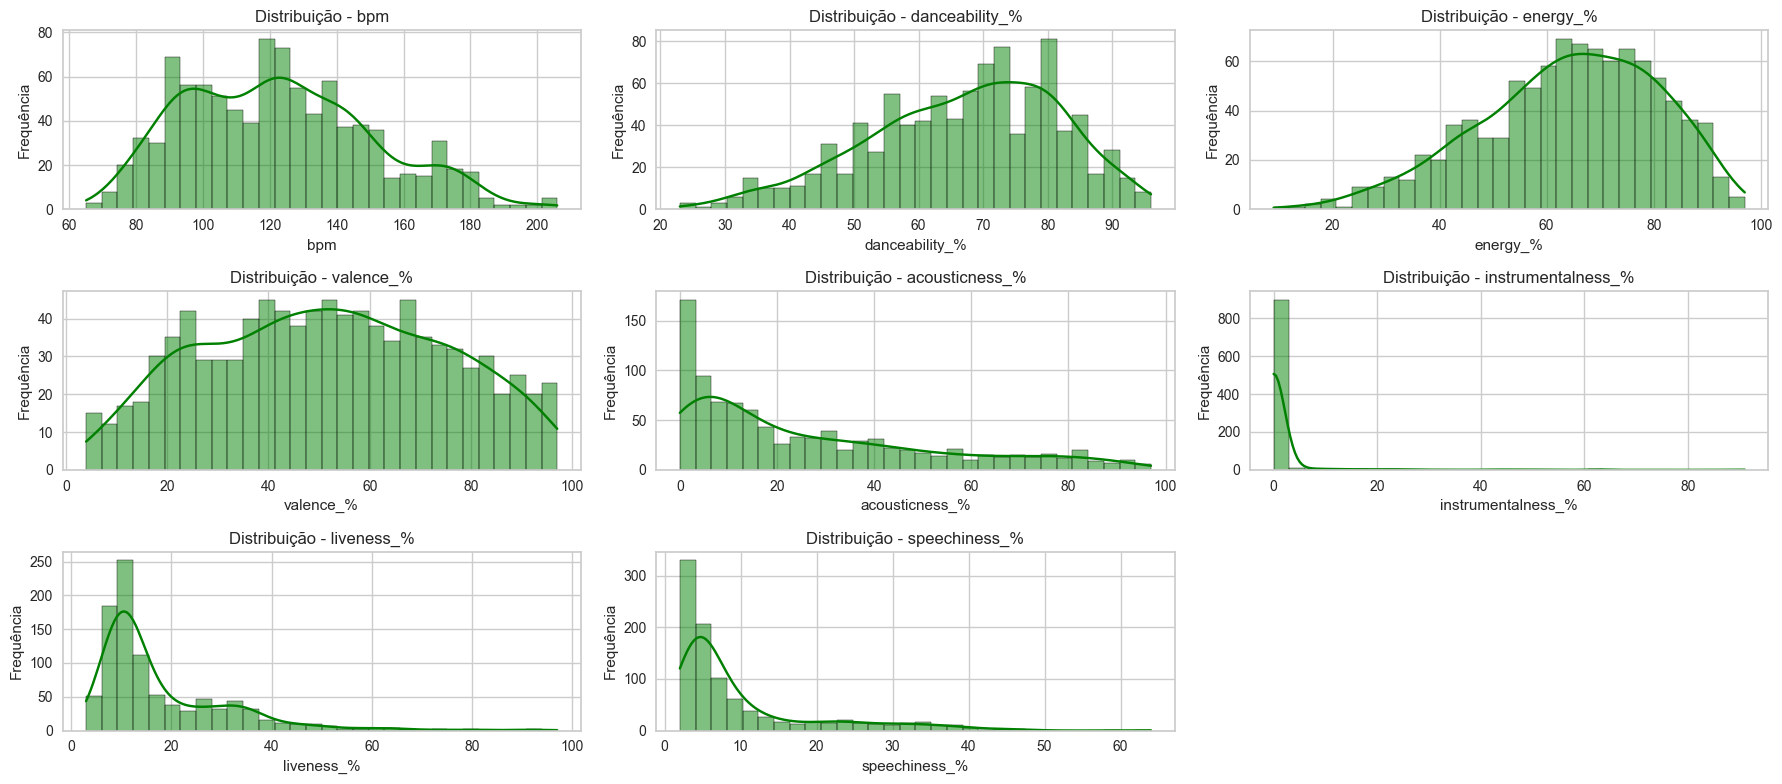

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))
axs = axs.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axs[i], color='green')
    axs[i].set_title(f'Distribuição - {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequência')

# Remove gráfico vazio (caso tenha)
for j in range(len(cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

**Observações:** temos curvas normais características.

* Matriz de correlação

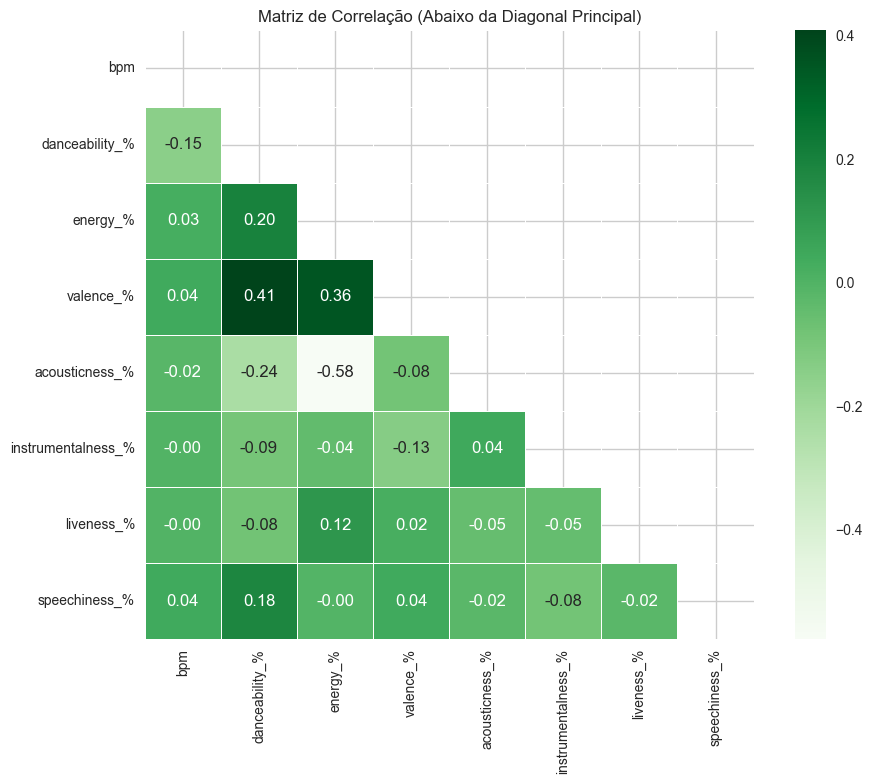

In [19]:
# Selecionar apenas as colunas numéricas relevantes
cols = ["bpm", "danceability_%", "energy_%", "valence_%","acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]

# Calcular matriz de correlação
correlation_matrix = df[cols].corr()

# Criar máscara para valores acima da diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotar heatmap com máscara
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    square=True,
    mask=mask,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Matriz de Correlação (Abaixo da Diagonal Principal)")
plt.tight_layout()
plt.show()

**Observação:** Como energy_% e accousticness_% possuem correlação de -60% temos uma correlação inversa forte, podemos descartar do nosso modelo uma das duas variáveis. Como energy_% de acordo com os gráficos da distribuição normal e boxplot possuem uma distribuição melhor, facilitando para o modelo durante a previsão.

## **2. Pré-processamento**

Verificação de nulos.

In [20]:
df.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  1
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
cover_url                0
dtype: int64

**Observação:** Como Key são denominações categóricas iremos substituir o valores nulos por unknown e para in_shazam_charts substituiremos por 0.

In [21]:
# Substituir valores nulos
df["key"] = df["key"].fillna("unknown")

df["in_shazam_charts"] = df["in_shazam_charts"].fillna(0)

# Converter colunas numéricas para float
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].astype(float)

# Converter colunas categóricas para string
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].astype(str)

df.dtypes.head(10)

track_name               object
artist(s)_name           object
artist_count            float64
released_year           float64
released_month          float64
released_day            float64
in_spotify_playlists    float64
in_spotify_charts       float64
streams                 float64
in_apple_playlists      float64
dtype: object

In [22]:
# Selecionar as colunas que serão usadas no clustering
features = ["bpm", "danceability_%", "energy_%", "valence_%", "liveness_%", "speechiness_%"]

# Remover linhas com valores ausentes nas colunas selecionadas
df_cluster = df[features].dropna()

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Exibir as primeiras 5 linhas normalizadas como DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled.head()

,bpm,danceability_%,energy_%,valence_%,liveness_%,speechiness_%
0,0.087708,0.891096,1.131729,1.600828,-0.745256,-0.618829
1,-1.089053,0.275624,0.587654,0.407730,-0.599314,-0.618829
2,0.551280,-1.092091,-0.681854,-0.827979,0.933082,-0.416966
3,1.692382,-0.818548,0.466749,0.279898,-0.526342,0.491420
4,0.765237,-0.134690,0.950371,-1.211475,-0.526342,-0.416966


## **3. Verificando quantidade de clusters**

### **3.1 Método Elbow**

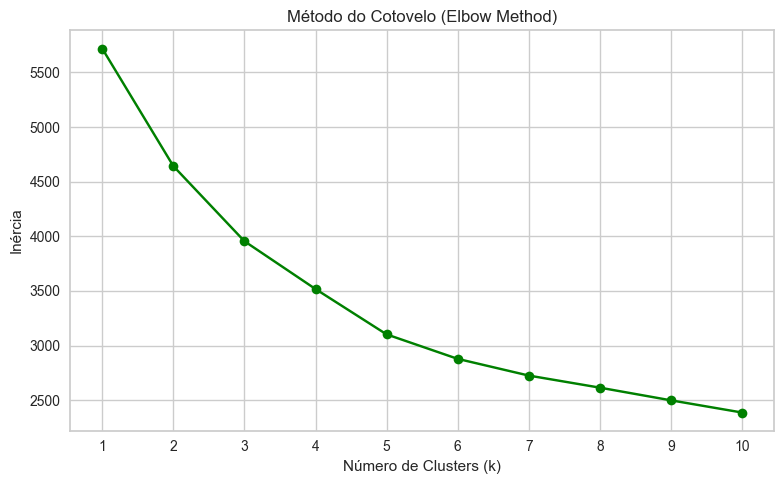

In [23]:
# Método do cotovelo (Elbow)
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', color='green')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

### **3.2 Método Silhouette**

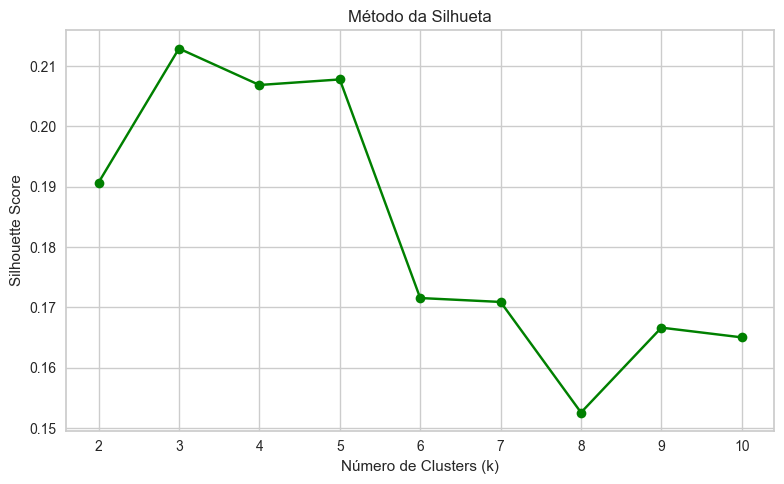

In [24]:
# Avaliar pontuação da silhueta para diferentes valores de k
silhouette_scores = []
k_range = range(2, 11)  # Silhouette só funciona para k >= 2

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot do método da silhueta
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Método da Silhueta')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

Os dois métodos nos recomenda fazer 3 clusters.

## **4. Modelagem**

In [25]:
n_clusters=4 # Vamos adotar 4 clusters para o KMeans, definido pela unidade de negócio como mínimo apesar do ideal pelos métodos ser 3

# Aplicando KMeans
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42)
df_scaled["cluster"] = kmeans_final.fit_predict(X_scaled)

# Exibir amostra com cluster atribuído
display(df_scaled.head())

,bpm,danceability_%,energy_%,valence_%,liveness_%,speechiness_%,cluster
0,0.087708,0.891096,1.131729,1.600828,-0.745256,-0.618829,1
1,-1.089053,0.275624,0.587654,0.407730,-0.599314,-0.618829,1
2,0.551280,-1.092091,-0.681854,-0.827979,0.933082,-0.416966,2
3,1.692382,-0.818548,0.466749,0.279898,-0.526342,0.491420,0
4,0.765237,-0.134690,0.950371,-1.211475,-0.526342,-0.416966,0


### **4.1 Visualização dos grupos**

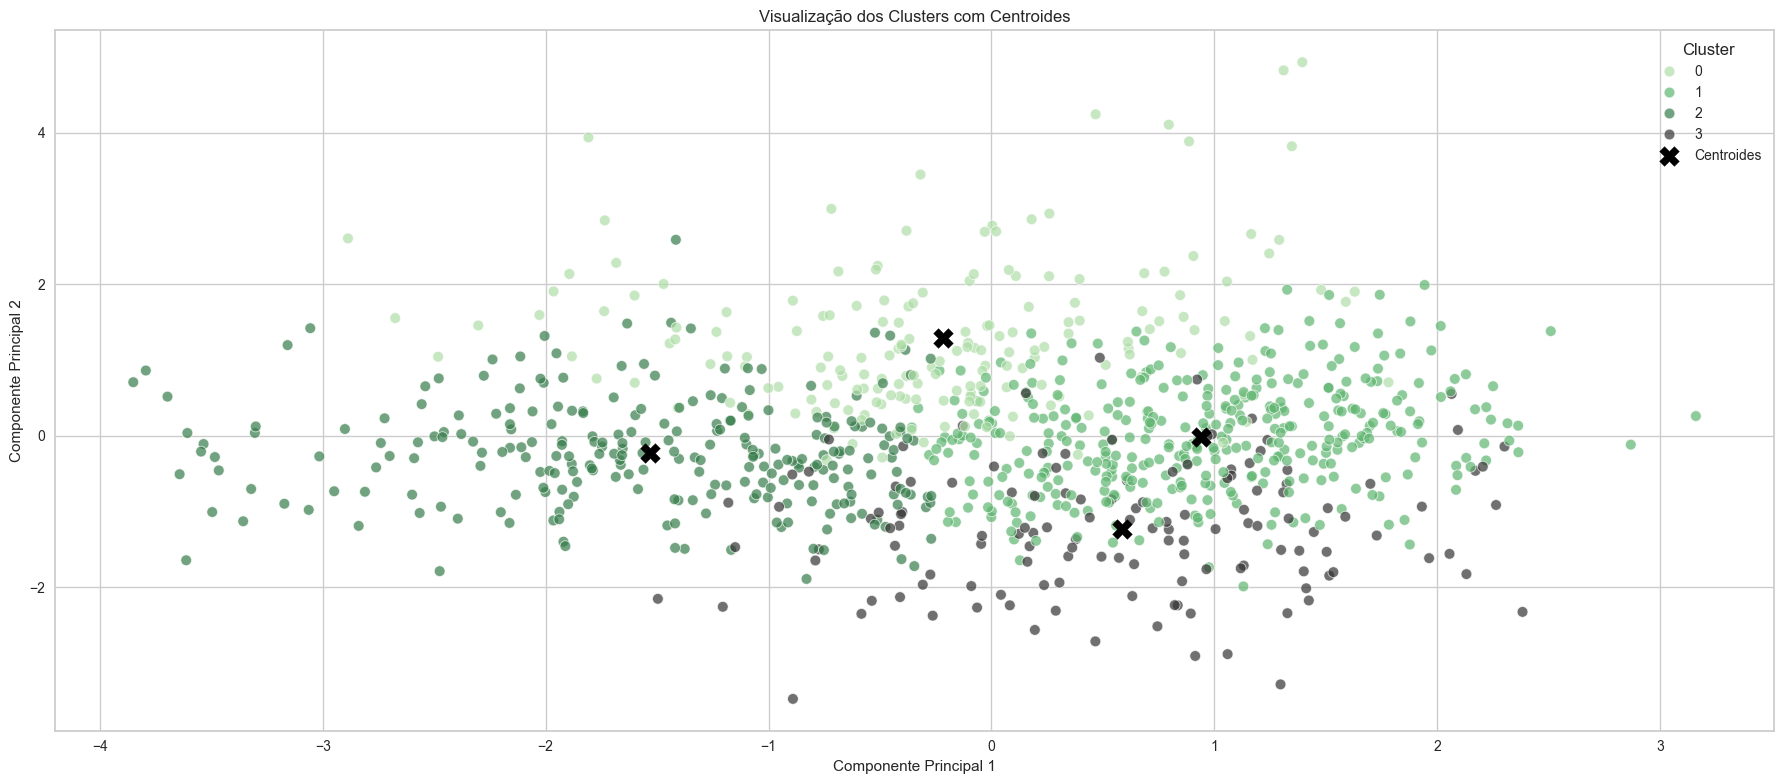

In [30]:
# Reaplicar PCA para garantir consistência
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transformar os centróides dos clusters para o espaço PCA
centroids = kmeans_final.cluster_centers_
centroids_pca = pca.transform(centroids)

# Adicionar componentes principais ao df_scaled
df_scaled["PCA1"] = X_pca[:, 0]
df_scaled["PCA2"] = X_pca[:, 1]

# Plotar os pontos com centróides
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=df_scaled,
    x="PCA1",
    y="PCA2",
    hue="cluster",
    palette="Greens_d",
    s=60,
    alpha=0.7
)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroides'
)
plt.title("Visualização dos Clusters com Centroides")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


### **4.2 Perfil médio dos grupos**

In [ ]:
cluster_profile = df_scaled.groupby("cluster")[features].mean().round(2)

display(cluster_profile)

,bpm,danceability_%,energy_%,valence_%,liveness_%,speechiness_%
cluster,,,,,,
0,1.11,-0.62,0.44,0.02,0.63,-0.26
1,-0.34,0.63,0.46,0.64,-0.14,-0.32
2,-0.30,-0.71,-0.90,-0.97,-0.13,-0.45
3,0.04,0.42,-0.14,0.04,-0.19,2.13


### **4.3 Juntando os clusters com os dados dos artistas**

In [ ]:
# 3. Juntar com colunas originais para visualizar nomes de faixas e artistas
# Garantir que os DataFrames estejam alinhados (usando o mesmo índice)
df_with_clusters = df.loc[df_scaled.index].copy()
df_with_clusters["cluster"] = df_scaled["cluster"].values

sample_clusters = df_with_clusters[["track_name", "artist(s)_name", "cluster"]].sort_values("cluster").reset_index(drop=True)
display(sample_clusters)

,track_name,artist(s)_name,cluster
0,"Would've, Could've, Should've",Taylor Swift,0
1,LADY GAGA,"Gabito Ballesteros, Junior H, Peso Pluma",0
2,Like Crazy,Jimin,0
3,Cruel Summer,Taylor Swift,0
4,WHERE SHE GOES,Bad Bunny,0
...,...,...,...
948,On BS,"Drake, 21 Savage",3
949,Starboy,"The Weeknd, Daft Punk",3
950,La Bebe - Remix,"Peso Pluma, Yng Lvcas",3
951,BILLIE EILISH.,Armani White,3


#### **4.3.1 Nomeando Clusters**

In [ ]:
cl_0 = sample_clusters[sample_clusters["cluster"] == 0].head(10)
cl_1 = sample_clusters[sample_clusters["cluster"] == 1].head(10)
cl_2 = sample_clusters[sample_clusters["cluster"] == 2].head(10)
cl_3 = sample_clusters[sample_clusters["cluster"] == 3].head(10)

display(cl_0, cl_1, cl_2, cl_3)

,track_name,artist(s)_name,cluster
0,"Would've, Could've, Should've",Taylor Swift,0
1,LADY GAGA,"Gabito Ballesteros, Junior H, Peso Pluma",0
2,Like Crazy,Jimin,0
3,Cruel Summer,Taylor Swift,0
4,WHERE SHE GOES,Bad Bunny,0
5,As It Was,Harry Styles,0
6,Celestial,Ed Sheeran,0
7,Typa Girl,BLACKPINK,0
8,El Azul,"Junior H, Peso Pluma",0
9,I'm Good (Blue),"Bebe Rexha, David Guetta",0


,track_name,artist(s)_name,cluster
181,Flowers,Miley Cyrus,1
182,Super Shy,NewJeans,1
183,un x100to,"Bad Bunny, Grupo Frontera",1
184,fukumean,Gunna,1
185,Ella Baila Sola,"Eslabon Armado, Peso Pluma",1
186,You Right,"Doja Cat, The Weeknd",1
187,Butter,BTS,1
188,Sad Girlz Luv Money Remix (feat. Kali Uchis),"Kali Uchis, Amaarae, Moliy",1
189,Life Goes On,Oliver Tree,1
190,Better Days (NEIKED x Mae Muller x Polo G),"NEIKED, Mae Muller, Polo G",1


,track_name,artist(s)_name,cluster
559,Love Nwantiti - Remix,"Ckay, AX'EL, Dj Yo!",2
560,Lost in the Fire,"The Weeknd, Gesaffelstein",2
561,Phantom Regret by Jim,The Weeknd,2
562,Dos Oruguitas,Sebastian Yatra,2
563,Daddy Issues,The Neighbourhood,2
564,Meet Me At Our Spot,"THE ANXIETY, Willow, Tyler Cole",2
565,The Astronaut,Jin,2
566,My Mind & Me,Selena Gomez,2
567,we fell in love in october,girl in red,2
568,Miss You,Southstar,2


,track_name,artist(s)_name,cluster
819,Sprinter,"Dave, Central Cee",3
820,TQG,"Karol G, Shakira",3
821,TO THE MOON,Jnr Choi,3
822,Knife Talk (with 21 Savage ft. Project Pat),"Drake, Project Pat, 21 Savage",3
823,The Family Madrigal,"Olga Merediz, Stephanie Beatriz, Encanto - Cast",3
824,Every Angel is Terrifying,The Weeknd,3
825,Privileged Rappers,"Drake, 21 Savage",3
826,BackOutsideBoyz,Drake,3
827,Broke Boys,"Drake, 21 Savage",3
828,California Breeze,Lil Baby,3


In [ ]:
# Acrescentar coluna com categorias de playlists
cat = []

for i in df_with_clusters["cluster"]:
    if i == 0:
        cat.append("Trilha das Estrelas")
    elif i == 1:
        cat.append("Calmamente Pop")
    elif i == 2:
        cat.append("Entre razões e emoções")
    else:
        cat.append("Flow Pesadão")

df_with_clusters["playlist_category"] = cat

# Exibir amostra
display(df_with_clusters[["track_name", "artist(s)_name", "cluster", "playlist_category"]].head(10))


,track_name,artist(s)_name,cluster,playlist_category
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",1,Calmamente Pop
1,LALA,Myke Towers,1,Calmamente Pop
2,vampire,Olivia Rodrigo,2,Entre razões e emoções
3,Cruel Summer,Taylor Swift,0,Trilha das Estrelas
4,WHERE SHE GOES,Bad Bunny,0,Trilha das Estrelas
5,Sprinter,"Dave, Central Cee",3,Flow Pesadão
6,Ella Baila Sola,"Eslabon Armado, Peso Pluma",1,Calmamente Pop
7,Columbia,Quevedo,2,Entre razões e emoções
8,fukumean,Gunna,1,Calmamente Pop
9,La Bebe - Remix,"Peso Pluma, Yng Lvcas",3,Flow Pesadão


## **5. Salvando base com Classificação de Clusters**

In [ ]:
save_cam = os.path.join(parent_dir, 'base_de_dados', 'Spotify clusters.xlsx')

df_with_clusters.reset_index(drop=True)

try:
    df_with_clusters.to_excel(save_cam, index=False, engine='openpyxl')

    print(f"Arquivo salvo em: {save_cam}")

except Exception as e:
    print(f"Erro ao salvar o arquivo: {e}")

Arquivo salvo em: c:\Users\leona\OneDrive\Documentos\MBA Eng Dados\Data Science\Projeto_netflix\base_de_dados\clusters.xlsx
